In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read Dataset
df_raw = pd.read_csv('vgames2.csv', index_col=0, na_values='Unknown')
num_df_before = df_raw.shape[0]

#refine Year
df_raw.loc[df_raw.Year<=22,'Year'] += 2000
df_raw.loc[df_raw.Year<=99,'Year'] += 1900

#refine Sales data
sales_col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for col in sales_col:
  df_raw[col] = df_raw[col].str.replace('M','')
  df_raw[col] = [(
      ele.replace('K', '') if re.match('.*K', ele) else round(float(ele) * 1000, 3)
      ) for ele in df_raw[col]]

df_raw[sales_col] = df_raw[sales_col].astype(float)
df_raw = df_raw.sort_values(['Name','Year','Genre']).reset_index(drop= True)

In [24]:
def ctrl_dupl_na(df_x):
  df_dupl = df_x[df_x.Name.duplicated(keep= False) == True].sort_values('Name')
  df_ret = df_x.copy()

  for col in ['Year', 'Genre', 'Publisher']:
    dupl_isna = df_dupl[col].isna()
    df_not_NA = df_dupl[dupl_isna == False]
    df_NA = df_dupl[dupl_isna == True]

    for i in df_NA.index:
      name = df_raw.loc[i, 'Name']
      df_sub = df_not_NA[df_not_NA['Name'] == name]
      if  df_sub.shape[0] > 0:
        df_ret.loc[i, col] = df_sub[col].iloc[0]

  return df_ret

In [25]:
#NA control
df = ctrl_dupl_na(df_raw)

df.info()
#df_raw.loc[df_raw.Name.str.contains('Racing'),'Genre'] = 'Racing'
#df_raw.loc[df_raw.Name.str.contains('Pokemon .*/Pokemon') == (df_raw.Genre.isna() == True),'Genre']# = 'Role-Playing'
#df_NA#raw[df_raw.Genre.isna() == True]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16451 non-null  float64
 3   Genre        16568 non-null  object 
 4   Publisher    16403 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.1+ MB


In [ ]:
#drop NAs
df = df.dropna(subset = ['Year', 'Genre']).reset_index(drop = True)
num_df_after = df.shape[0]

In [ ]:
#re-define data type
df[['Platform', 'Genre', 'Publisher']] = df[['Platform', 'Genre', 'Publisher']].astype('category')
df[sales_col] = df[sales_col].astype(int)
df = df.convert_dtypes()

In [ ]:
#Data Featuring
df['Total_Sales'] = np.sum(df[sales_col].T)

In [ ]:
print(f'The number of    RAW data: {num_df_before}\nThe number of not-NA data: {num_df_after}\nduration: {np.amin(df.Year)} ~ {np.amax(df.Year)}')
df.info()

The number of    RAW data: 16598
The number of not-NA data: 16277
duration: 1980 ~ 2020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16277 entries, 0 to 16276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         16277 non-null  string  
 1   Platform     16277 non-null  category
 2   Year         16277 non-null  Int64   
 3   Genre        16277 non-null  category
 4   Publisher    16241 non-null  category
 5   NA_Sales     16277 non-null  Int64   
 6   EU_Sales     16277 non-null  Int64   
 7   JP_Sales     16277 non-null  Int64   
 8   Other_Sales  16277 non-null  Int64   
 9   Total_Sales  16277 non-null  int64   
dtypes: Int64(5), category(3), int64(1), string(1)
memory usage: 1.0 MB


In [ ]:
def make_lineplot(df, min=1900, max=2022):
  df_wide = df.\
    loc[(df.Year >= min) & (df.Year <= max),['Year', 'Genre', 'Total_Sales']].\
    groupby(['Year', 'Genre'])['Total_Sales'].mean().reset_index()
  
  plt.figure(figsize= [16, 12])
  sns.lineplot(data= df_wide, x= 'Year', y= 'Total_Sales', hue= 'Genre')
  plt.legend();

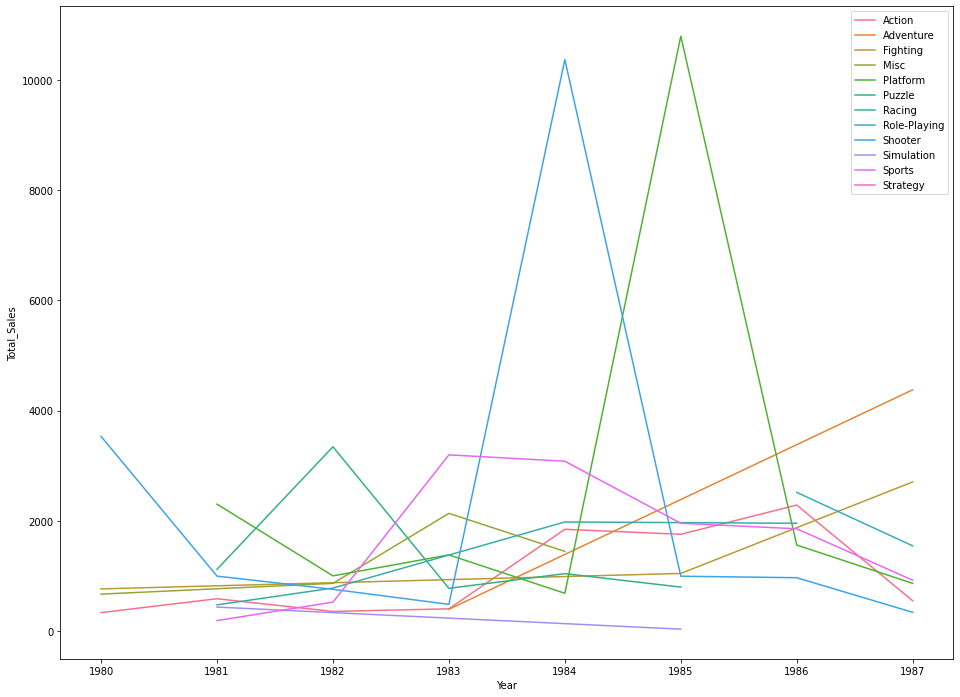

In [ ]:
make_lineplot(df, min = 1980, max=1987)

In [ ]:
def make_pie(df, min=1900, max=2022):
  df_gs = df[(df.Year >= min) & (df.Year <= max)].\
    groupby('Genre')[sales_col].sum().sort_values('NA_Sales')

  plt.figure(figsize= [16, 16])
  for i, sale in enumerate(sales_col):
    x = plt.subplot(2, 2, i+1)
    x.ax = plt.pie(data= df_gs, x= sale, labels=df_gs.index)
    plt.title(sale)

  plt.legend();

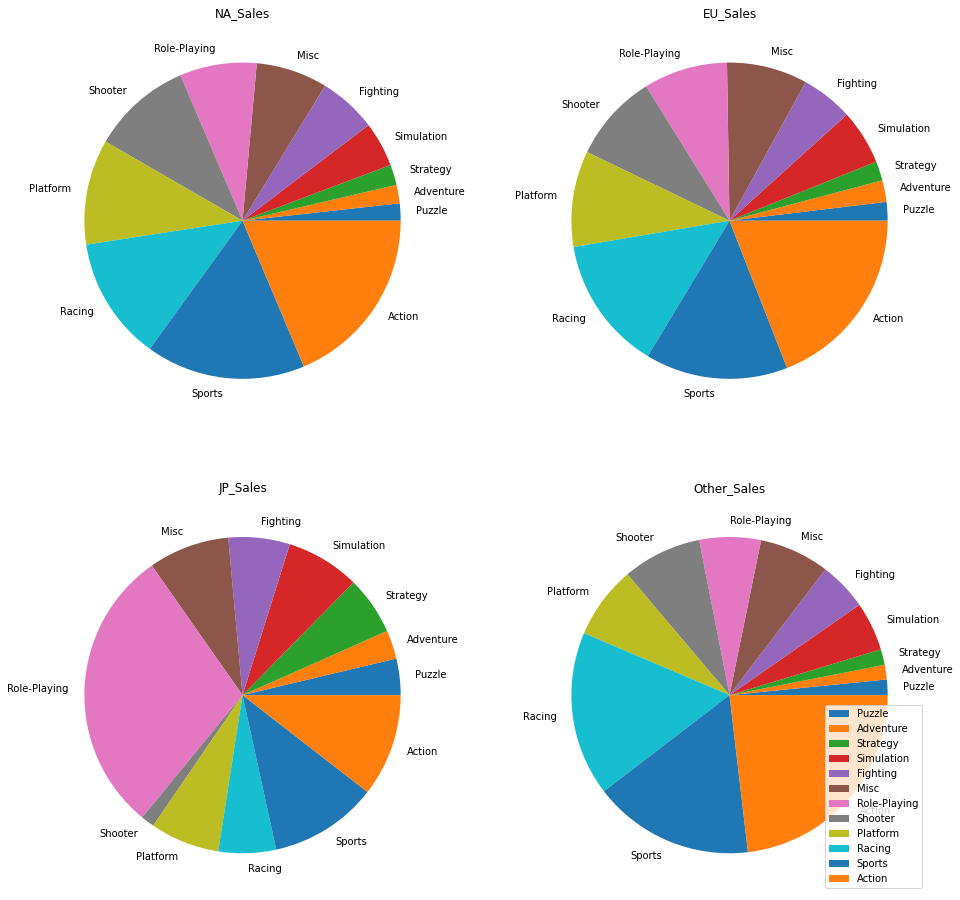

In [ ]:
make_pie(df, min= 1999, max = 2005)